Hey there! This notebook's purpose is to create a smoothed version of the of actigraphy dataset in wide format (X) and then pair it with a vector containing sleep disorder data (y) <br>
The data is saved as a pickle file for use in other notebooks

#Setup

In [1]:
#google drive
from google.colab import drive
drive.mount('/content/drive')

#imports
import pandas as pd
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Useful Functions

In [2]:
# Function that returns list with overlapping elements 
def intersection(list1, list2):
    list3 = []
    for element in list1:
        if element in list2:
            list3.append(element)
    return list3

# Function that returns list1 element that don't overlap with list2
def no_intersection(list1, list2):
    list3 = []
    for element in list1:
        if element not in list2:
            list3.append(element)
    return list3

# Formatting Data

In [3]:
# Load data
raw_sleep_disorder_data = pd.read_sas('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/data/SLQ_H.XPT')
raw_actigraphy_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/allMinData.pkl')

# Take out incomplete days 
raw_actigraphy_data = raw_actigraphy_data.loc[(raw_actigraphy_data['PAXDAYM'] != b'1') & (raw_actigraphy_data['PAXDAYM'] != b'9')]
#Sleep disorder table of SEQN -> {0,1} such that 0 is no sleep disorder 1 is sleep disorder
raw_sleep_disorder_data["sleep_disorder"] = raw_sleep_disorder_data['SLQ060'].apply(lambda x: x if x==1 else 0)
sleep_disorder = raw_sleep_disorder_data[["SEQN","sleep_disorder"]]

In [4]:
## find Intersection ## 

#Make set of sleep data
sleep_set = sleep_disorder['SEQN'].unique().tolist()
has_sleep_disorder_set = sleep_disorder[sleep_disorder['sleep_disorder']==1]['SEQN'].unique().tolist()

print("number of sleep disorders", len(has_sleep_disorder_set))
print("number of total surveyed", len(sleep_set))
#list of actigraphy
act_set = raw_actigraphy_data['SEQN'].unique().tolist()

#has both activity and sleep data
SEQN_act_sleep = intersection(act_set,sleep_set)

number of sleep disorders 579
number of total surveyed 6464


ALTER block below if you want smoothed or not smoothed data

In [5]:
## change sleep data to wide format ##

#Create a datatable where Intensity is turned into a list and grouped by SEQN
t = raw_actigraphy_data[['SEQN','PAXMTSM']].groupby('SEQN').aggregate(lambda inten: inten.tolist()).reset_index()
t['Smoothed'] = t['PAXMTSM'].apply(lambda x: savgol_filter(np.array(x), 51, 2))

# #turn it into wide format (table format)
wide_X = pd.DataFrame(t['PAXMTSM'].tolist())
wide_X.insert(0, 'SEQN', t["SEQN"])
# #turn it into week long data 

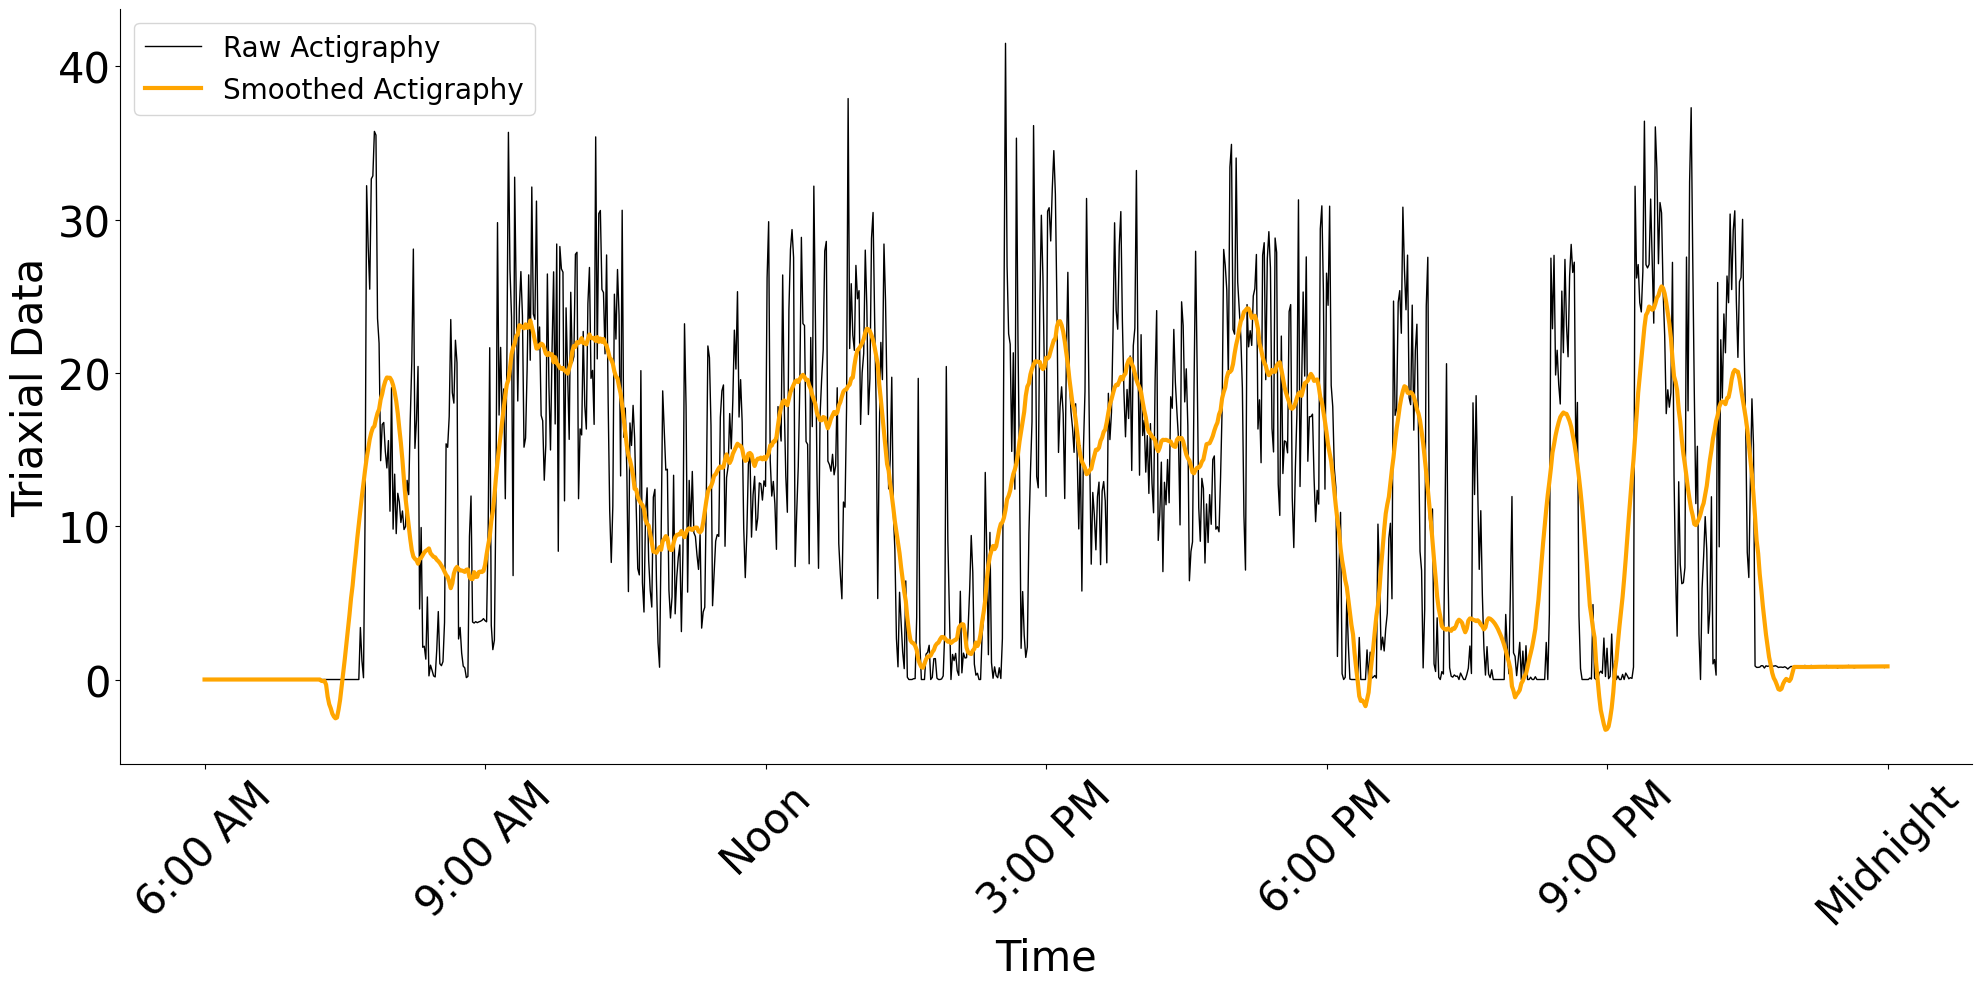

<Figure size 640x480 with 0 Axes>

In [15]:
# Smoothed Plot Comparison

from matplotlib.ticker import MaxNLocator
# Plot Patient #0 day 1
x = range(360, 1440+1)
row = t['PAXMTSM'][0][360:1441]
row_hat = savgol_filter(row, 51, 2)
len(row_hat)

# Figure plotting 
plt.style.use("default")

fig, ax = plt.subplots(1,1, figsize=(20, 10), sharey = True, sharex = True) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params('y', labelsize = 30)
locator=MaxNLocator(prune='both', nbins=7)
ax.xaxis.set_major_locator(locator)
ax.tick_params('x',labelrotation=45, labelsize = 30)
xticklabels = ['6:00 AM',
                      '9:00 AM', 'Noon', '3:00 PM',
                      '6:00 PM', '9:00 PM', 'Midnight']
plt.setp((ax), xticks = [360,540,720,900,1080,1260,1440],
        xticklabels = ['6:00 AM',
                      '9:00 AM', 'Noon', '3:00 PM',
                      '6:00 PM', '9:00 PM', 'Midnight'])

plt.plot(x, row, color='black',linewidth=1.0, label="Raw Actigraphy")
plt.plot(x, row_hat, color='orange', linewidth=3.0, label="Smoothed Actigraphy")
plt.legend(fontsize = 20)
plt.xlabel("Time", fontsize=30)
plt.ylabel("Triaxial Data", fontsize=30)
#format
fig.tight_layout()
plt.show()
plt.clf()
#plt.savefig('big_plot', dpi = 500)

In [ ]:
# # ensure that all SEQNS in X contain data
# wide_X = wide_X.loc[wide_X['SEQN'].isin(sleep_set)]
# # append sleep disorder data 
# y = wide_X["SEQN"].apply(lambda x: 1 if (x in has_sleep_disorder_set) else 0)
# wide_X.to_pickle("/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/wideX_UnSmoothed.pkl")  
# y.to_pickle("/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/y_UnSmoothed.pkl")